<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PEC4</p>
<p style="margin: 0; text-align:right;">2021-1 · Master universitari en Ciencia de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimedia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 4: Sèries temporals i Combinació de classificadors
Aquesta pràctica està dividida en dues parts:

En el primer exercici veurem com **descompondre i compondre sèries temporals per fer prediccions a futur**.

Al segon exercici estudiarem **diferents mètodes de combinació de classificadors**. 


1. Descomposició i composició de sèries temporals per fer prediccions
        1.1. Components de la sèrie temporal
           1.1.a Heterocedasticitat
           1.1.b Tendència
           1.1.c Estacionalitat
        1.2. Prediccions
           1.2.a Predicció SARIMA
           1.2.b Tendència
           1.3.c Heterocedasticitat
2. Mètodes de combinació de classificadors
        2.1. Combinació paral·lela de classificadors
           2.1.1 Arbres de decisió
           2.1.2.a Bagging
           2.1.2.b Boosting
        2.2. Combinació seqüencial de classificadors de base diferent
           2.2.1 KNN
           2.2.2 SVM
           2.2.3 Stacking
           2.2.4 Cascading

**Important: L'exportació del notebook a html es pot fer des del menú File $\to$ Download as $\to$ HTML.** 

<div class="alert alert-block alert-info">
<strong>Nom i cognoms:</strong>
</div>

# Introducció
Una sèrie temporal (time series) és una successió de dades ordenades cronològicament, espaiades a intervals iguals o desiguals. El procés de Forecasting consisteix a predir el valor futur d'una sèrie temporal, bé modelant la sèrie temporal únicament en funció del seu comportament passat (autoregressiu) o emprant altres variables externes a la sèrie temporal.

Al llarg d'aquest document, es descriu com utilitzar models de regressió de Scikit-learn per fer forecasting sobre sèries temporals 

In [1]:
pip install session-info

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Tractament de dades
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels
import math

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import ensemble

from pandas.plotting import autocorrelation_plot 

# Gràfics
# ==============================================================================
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

%matplotlib inline

# Configuració warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

El dataset (corticoides.csv) que s'utilitzarà en aquest primer exercici s'ha obtingut del llibre de forecasting de sèries temporals: [Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

Es disposa d'una sèrie temporal amb la despesa mensual (milions de dòlars) en fàrmacs amb corticoides que va tenir el sistema de salut Australià entre el 1991 i el 2008. Es pretén crear un model autoregressiu capaç de predir la futura despesa mensual. 

In [3]:
datos = pd.read_csv('corticoides.csv', sep=',')
datos.head()

,x,fecha
0,0.429795,1991-07-01
1,0.400906,1991-08-01
2,0.432159,1991-09-01
3,0.492543,1991-10-01
4,0.502369,1991-11-01


La columna data s'ha emmagatzemat com a string. Per convertir-la en datetime, es fa servir la funció pd.to_datetime(). Un cop en format datetime, i per fer ús de les funcionalitats de pandes, s'estableix com a índex. A més, atès que les dades són mensuals, se n'indica la freqüència (Monthly Started 'MS'). 

In [4]:
# Preparació de dades
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

Verifiquem que la sèrie temporal estigui completa.

In [5]:
# Verificar que un índex temporal està complet
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

Utilitzarem els darrers 36 mesos com a conjunt de tests per avaluar la capacitat predictiva del model. 

In [6]:
TEST_SIZE = 36
train, test = datos.iloc[:-TEST_SIZE], datos.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], datos.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((168,), (168,), (36,), (36,))

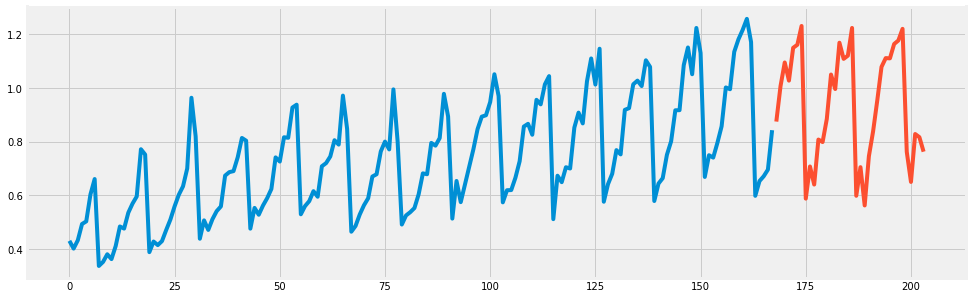

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

# Sèries temporals (5 punts)
## 1.1 Components de la sèrie temporal (2.5 punts)
### 1.1.a. Heterocedasticitat
Es diu que una sèrie temporal té [heterocedasticitat](https://es.wikipedia.org/wiki/Heterocedasticidad) quan la variància varia amb el temps .

El funcionament correcte del model de regressió lineal està basat en el compliment d'una sèrie d'hipòtesis entre les quals destaquen les relacionades amb l'error, que són:

El terme error és completament aleatori i segueix una distribució normal, d'esperança 0. La variància de l'error és constant al llarg de les observacions del model (Var[εi]=σ2). El terme error no està correlacionat entre els elements del model i també és independent de la variable explicativa. L'heteroscedasticitat és un problema que sorgeix amb l'incompliment de la segona hipòtesi, la qual cosa implica que la variància de l'error ha de ser constant al llarg de les observacions.

En el nostre cas, observem que tenim heterocedasticitat, ja que l'amplitud d'ona varia amb el temps. En aquest primer apartat heu d'eliminar l'heterocedasticitat de la sèrie temporal. És a dir, que la diferència entre el mínim i el màxim de l'estacionalitat (anual) sigui més o menys al llarg del temps.

**Ajuda**: Per saber quina transformació elimina millor l'heterocedasticitat, hem de veure tant numèricament com visualment quina presenta la menor variància. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Transformació de les dades per eliminar l'heterocedasticitat. Per fer això heu de transformar les dades aplicant la funció que considereu que elimina millor l'heterocedasticitat al dataset (exponencial, logarítmica, ...). Aquestes funcions ja estan implementades a numpy. Graficar les dades originals juntament amb les dades transformades.
</div> 

Apliquem -les diferents transformacion sobre els elements de la serie per tal de corretgir l'heterocedasticitat i així estabilitzar la variancia.

    - Transformació logarítmica
    - Transformació exponencial quadràtrica
    - Transformació quadràtica

In [8]:
def plot_serie(train_data, test_data, title):
    
    plt.style.use('default')
    
    # printem la serie
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.plot(x_train, train_data, label = 'Train')
    ax.plot(x_test, test_data, label = 'Test')
    ax.set_title('Transformació ' + title)
    plt.xlabel('Fecha')
    plt.ylabel(title)
    plt.legend(loc = 'best')
    

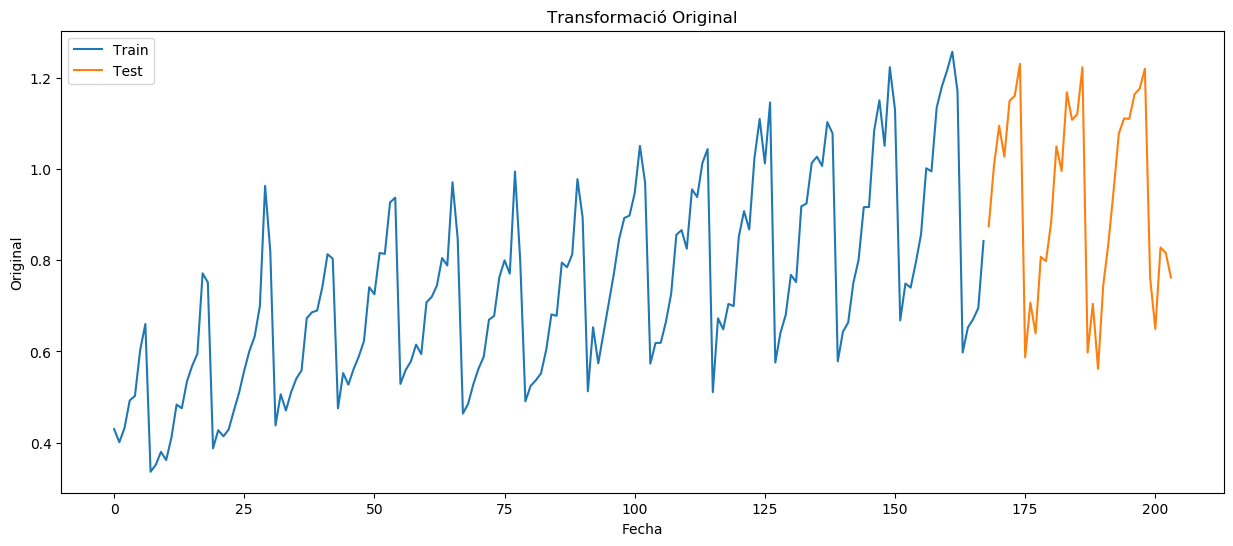

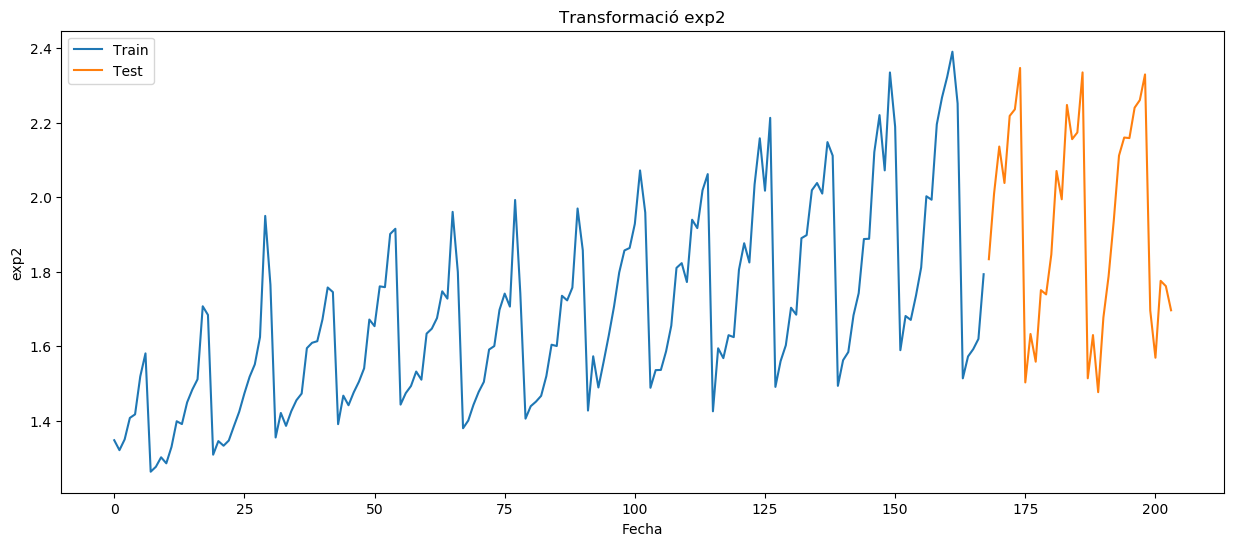

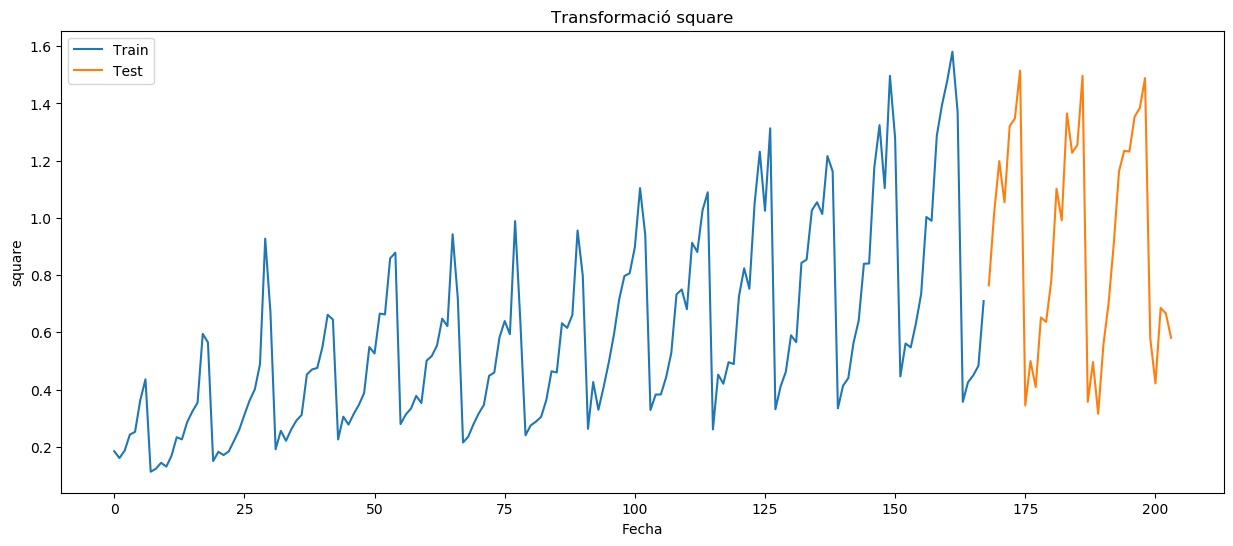

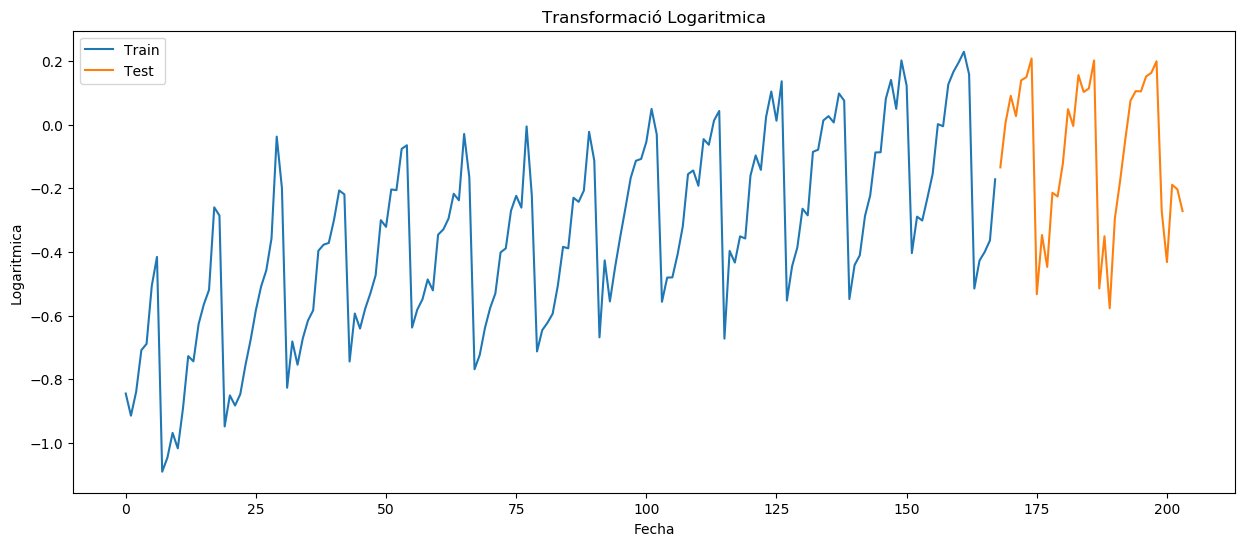

In [9]:
# executem la funció original
plot_serie(train, test, 'Original')

# realitzem la transformació exp2 (2^x)
train_exp2 = np.exp2(train)
test_exp2 = np.exp2(test)
plot_serie(train_exp2, test_exp2, 'exp2')

# realitzem la transformació square
train_sq = np.square(train)
test_sq = np.square(test)
plot_serie(train_sq, test_sq, 'square')

# realitzem la transformació logarítmica
train_log = np.log(train)
test_log = np.log(test)
plot_serie(train_log, test_log, 'Logaritmica')

El que hem realitzat és una transformació sobre les dades originals per tal d'estabilitzar la variancia. En la primera tranformació (exp2) no sembla que hem reduït gaire i tampoc amb quadràtica (square). Tenim amples d'ona més grans que els altres per tant els errors seran més grans en cada un dels cicles. En canvi, amb la transformació logarítmica sí que hem aconseguit aplanar l'ample d'algunes ones i deixar-les més homogèneas.

### 1.1.b. Tendència

La [tendència](https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png) és el comportament que té les dades a llarg termini.

A la nostra sèrie temporal tenim una tendència lineal creixent. En aquest apartat heu d'eliminar la tendència, quedant una sèrie temporal amb tendència constant. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Eliminar la tendència de les dades. Si observem la sèrie podem apreciar que tenim una tendència lineal, podem ajustar una regressió lineal (usant scikit-learn) i sostreure-la a les dades originals (sense heterocedasticitat). Graficar les dades amb tendència juntament amb les dades sense tendència.
</div> 

Visualment la tendéncia de la serie és pot apreciar de forma fàcil i és veu que va en augment. De totes formes podem extreure aquesta descomposant la serie en les seves diferents parts. Crearem una funció per a veure o bé totes les parts o alguna en concret.

Farem servir la classe decompose per a mostrar la serie descomposada en els elements:
   
    - Observed: La serie original que hem descomposat.
    - Trend: la tendència de la serie.
    - Seasonal: el component estacional de la serie.
    - Resid: els residus de la serie.


In [10]:
def seasonal_decompose_plot(data, part: str or None = None):

    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (6,6)
    
    serie_dec = seasonal_decompose(data.dropna(), model='additive')
    
    if (part == None):
        fig, axes = plt.subplots(2, 2)

        axes[0, 0].plot(serie_dec.observed)
        axes[0, 0].set_title('y: Observed')
        axes[0, 0].set_xlabel('Data')
        axes[0, 0].set_ylabel('Despesa en corticoides')    
        
        axes[0, 1].plot(serie_dec.trend)
        axes[0, 1].set_title('Trend')
        axes[0, 1].set_xlabel('Data')
        axes[0, 1].set_ylabel('Despesa en corticoides')  
        
        axes[1, 0].plot(serie_dec.seasonal)
        axes[1, 0].set_title('Seasonal')
        axes[1, 0].set_xlabel('Data')
        axes[1, 0].set_ylabel('Despesa en corticoides')
             
        axes[1, 1].plot(serie_dec.resid)
        axes[1, 1].set_title('Residuals')
        axes[1, 1].set_xlabel('Data')        
        axes[1, 1].set_ylabel('Despesa en corticoides')
    else:
                
        plt.rcParams['figure.figsize'] = (11,6)
                
        fig, axes = plt.subplots()
        
        axes.plot(getattr(serie_dec, part))
        axes.set_title(part.capitalize())
        axes.set_xlabel('Data')
        axes.set_ylabel('Despesa en corticoides')
        
    fig.suptitle('Descomposició de la Serie', fontsize=12)                  
    plt.show()

Descomposemt la serie i mostrem només la tendència. Veiem clarament que va en augment com ja havíem previst. 

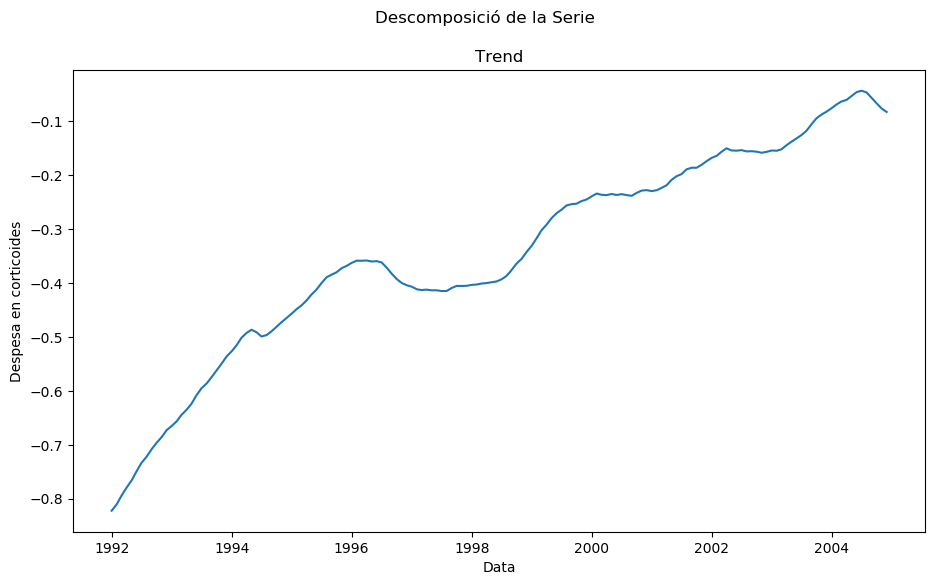

In [11]:
seasonal_decompose_plot(train_log, part= 'trend')

Ara modelarem la tendència general mitjançant un model de regressió lineal on podrem veure també el pendent d'inclinació. La farem servir per a obtenir les dades residuals i sostreient aquestes de les originals per extreure la tendència.

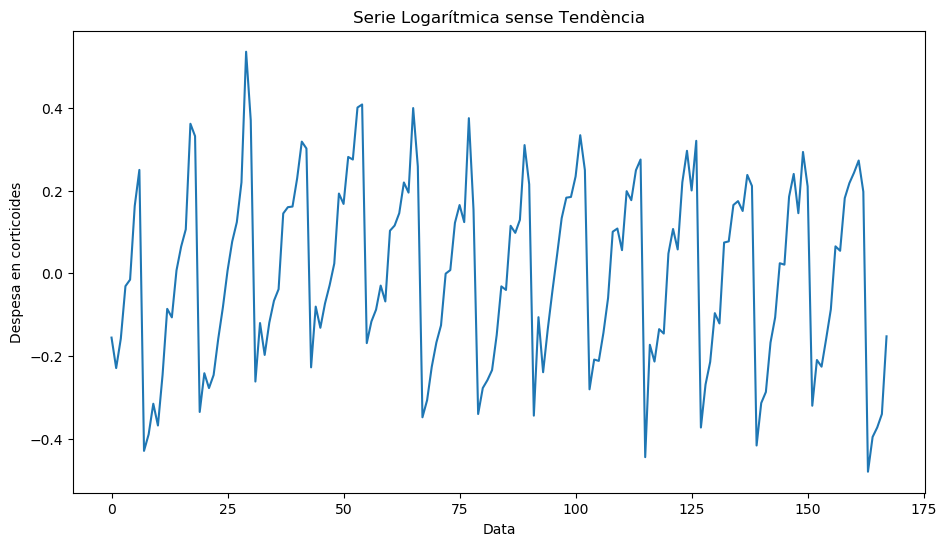

In [12]:
regr = LinearRegression(normalize=True, fit_intercept=True)

# entrenem el model
regr.fit(x_train.reshape(-1, 1), train_log)

# realitzem la predicció
train_regr = regr.predict(x_train.reshape(-1, 1))

# sostreiem els valors predits dels originals
train_log_no_trend = train_log - train_regr

# printem els residus
plt.figure(figsize=(11,6))
plt.xlabel('Data')
plt.ylabel('Despesa en corticoides')
plt.title('Serie Logarítmica sense Tendència')
plt.plot(x_train, train_log_no_trend) 

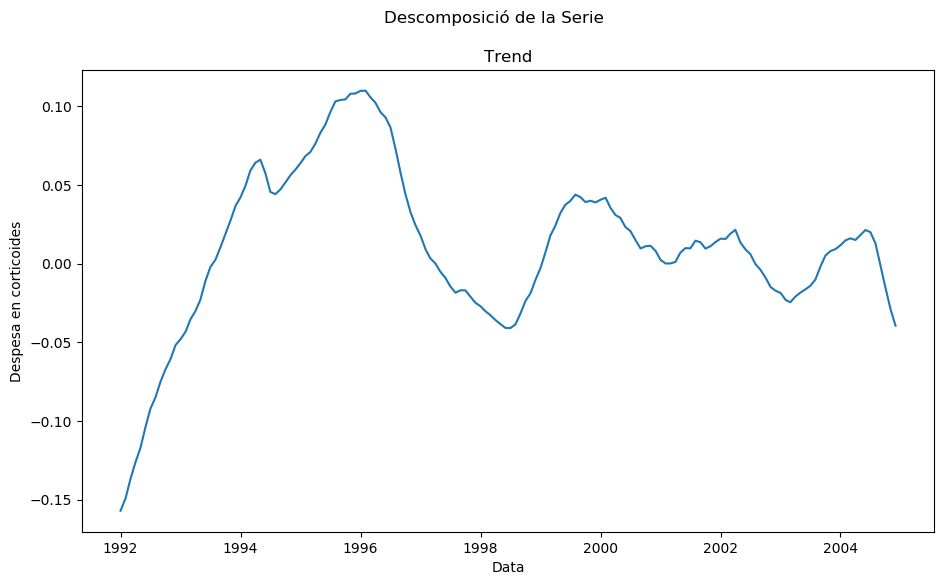

In [13]:
seasonal_decompose_plot(train_log_no_trend, part= 'trend')

Un cop hem aplicat la transformació podem veure que la tendència al llarg del temps en la serie és manté estable i si mostrem la tendencia també. 

Una altre forma de fer-ho és restar a les dades originals (amb l'aplicació logarítmica que ja hem fet) la tendència o trend de la serie. Al final la regressió lineal que hem aplicat ens dona també la tendència al descomposar la serie.

### 1.1.c. Estacionalitat

Definim [estacionalitat](https://analisisdedatos.net/analisis/ST/estacionariedad.php) com la variació cíclica que es produeix a les dades. En aquest apartat cal trobar i eliminar l'estacionalitat. 

#### 1.1.c.a. Trobar el període de l'estacionalitat

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> En primer lloc heu de trobar el cicle, és a dir, cada quan es repeteixen les dades. Per això podem fer servir l'autocorrelació (numpy et permet obtenir els coeficients de correlació). Graficar els coeficients per als 24 primers valors d'autocorrelació i determinar-ne el valor màxim, aquesta serà la nostra estacionalitat. Donar una interpretació semàntica del resultat obtingut.
</div> 

Mostrem l'estacionalitat de la serie un cop hem eliminat la heterocedasticitat i la tendéncia.

Podem veure a la serie temporal la venta de medicaments amb els cicles anuals. Sembla que els valors inician en un mínim i conforme va avançant l'any és va augmentant aquesta despesa fins que a l'inici de lany següent tornan a caure.

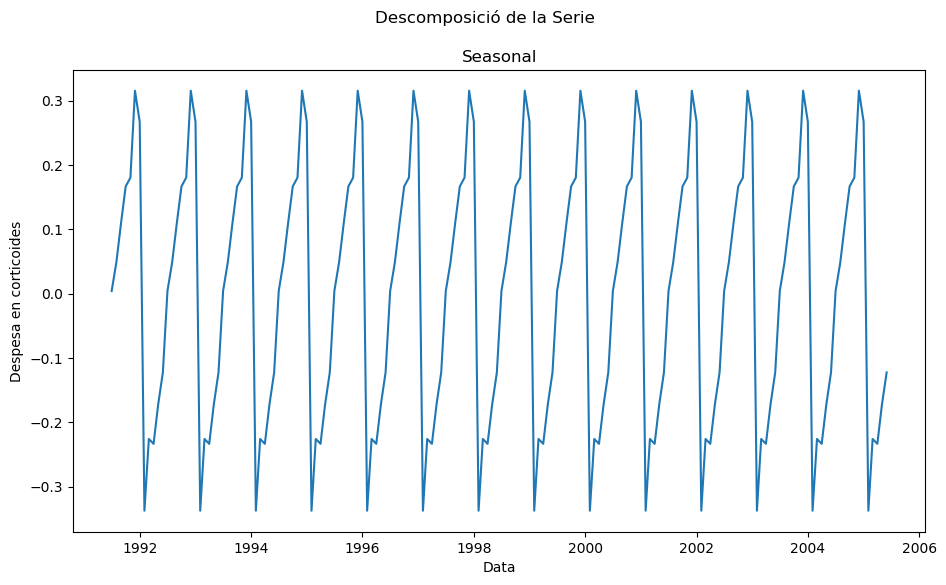

In [14]:
seasonal_decompose_plot(train_log_no_trend, 'seasonal')

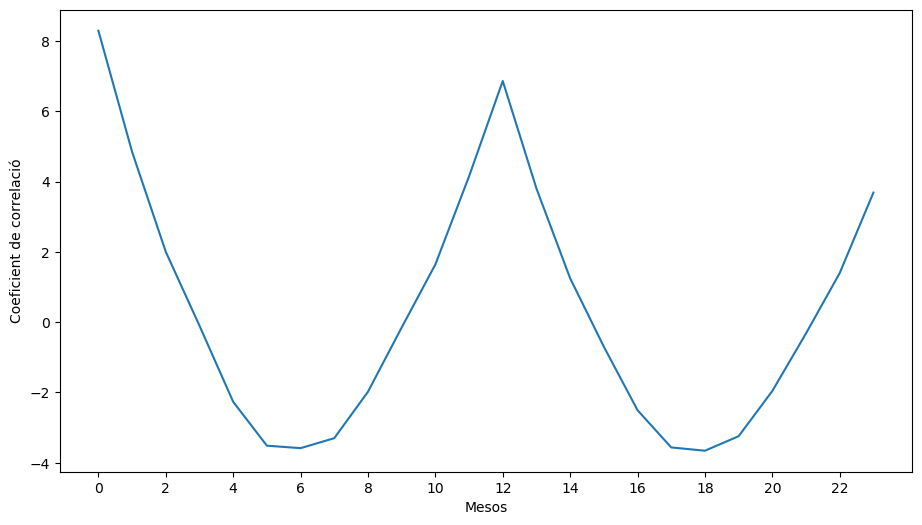

In [15]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

autocorr_values = autocorr(train_log_no_trend)
plt.xlabel("Mesos")
plt.ylabel("Coeficient de correlació")
plt.xticks(np.arange(0, 24, 2))
#plt.xlim([0, 24])
plt.plot(autocorr_values[:24])

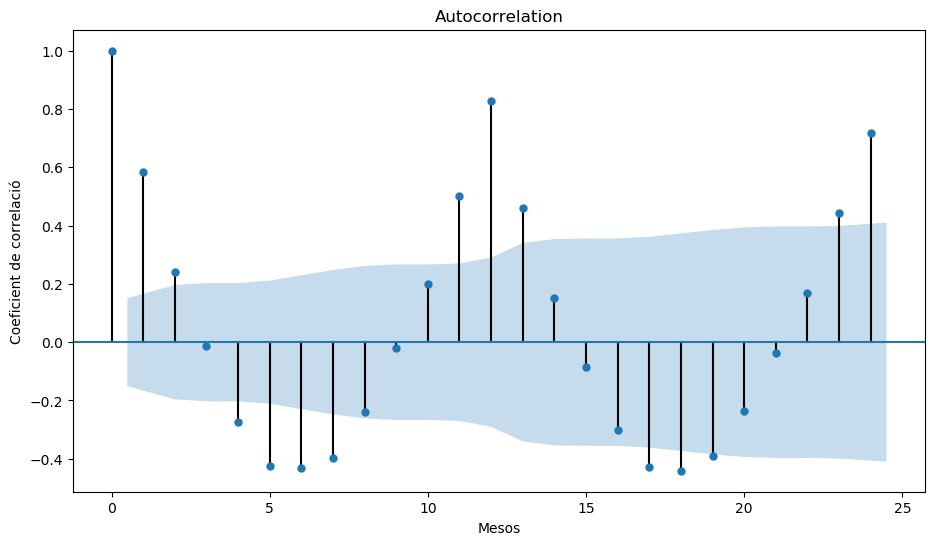

In [16]:
fig = plot_acf(train_log_no_trend, lags=24)

plt.xlabel("Mesos")
plt.ylabel("Coeficient de correlació")
plt.show()

Si ens fixem en els màxims consecutius podem veure que hi han 12 mostres per cada pic per tant els períodes són de 12.

#### 1.1.c.b. Aplicar un model SARIMA

Per tractar l´estacionalitat aplicarem un model SARIMA. Les sigles corresponen a “stationality ARIMA”, és a dir, un model ARIMA amb estacionalitat (la que acabem de trobar).

El model [ARIMA](https://otexts.com/fpp2/arima.html) ens permetrà tractar el soroll que queda en eliminar l'heterocedasticitat, tendència i estacionalitat. Per fer-ho té en compte els components següents:

- AR: auto-regressive, es denomina *p*. Té en compte la correlació amb els seus lags, és a dir, mira si les observacions passades afecten per calcular el punt següent.
- I: integrated, s'anomena *d*. És l'ordre de diferenciació, en el nostre cas no cal, ja que la sèrie ja no té heterocedasticitat ni tendència. Per tant la nostra *d* = 0
- MA: moving-average, s'anomena *q*. Té en compte la correlació amb els lags dels errors, és a dir, un cop s'ha aplicat el model, mira els errors del model vers les dades reals.

Els models SARIMA depenen de diversos paràmetres (p,d,q)(P,D,Q)s, on els primers (minúscules) corresponen a AR, I, MA de la sèrie normal, o els segons (majúscules) a AR, I, MA amb estacionalitat.

Per trobar aquests paràmetres hem de mirar els gràfics PACF (<i>partial autocorrelation function</i>) i ACF (<i>autocorrelation function</i>).

El gràfic PACF ens determina el paràmetre *p*, és a dir, l'AR. 

Descriurem cadascuna de les parts:

#### Què entenem per autocorrelació a les sèries temporals?
És un terme estadístic que s'utilitza per descriure la presència o absència de correlació a les dades de les sèries temporals, indicant, si les observacions passades influeixen en les actuals.

Per tant, podem dir que l'autocorrelació fa referència quan els valors que prenen una variable en el temps no són independents entre si, sinó que un valor determinat depèn dels valors anteriors.

El problema de l'autocorrelació s'anomena sovint de **“correlació serial”**.

Per mesurar l'autocorrelació se sol fer servir:


La **funció d'autocorrelació (ACF)**:
- Mesura la correlació entre dues variables separades per k períodes.
- Mesura el grau d'associació lineal que hi ha entre dues variables del mateix procés estocàstic.

La **funció d'autocorrelació parcial (PACF)**
- Mesura la correlació entre dues variables separades per k períodes quan no es considera la dependència creada pels retards intermedis existents entre ambdues.
- Mesura l'autocorrelació que hi ha entre dues variables separades k períodes descomptant els possibles efectes deguts a variables intermèdies.

Per tant, la funció ACF és usada per identificar el procés de mitjana mòbil (MA) en un model ARIMA; mentre que la funció PACF es fa servir per identificar els valors de la part del procés autoregressiu (AR).

Els gràfics generats a partir d'aquestes funcions es denominen **correlogrames**, els quals contenen bandes amb un interval de confiança del 95%. 

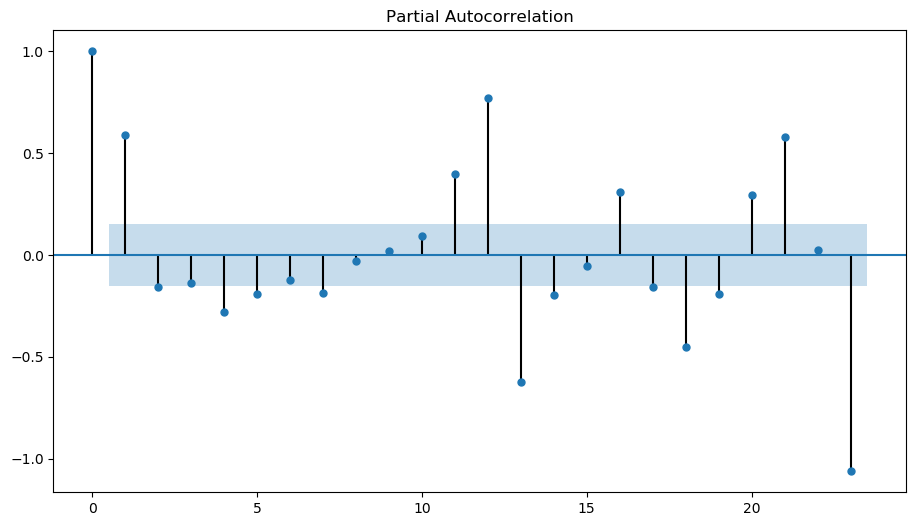

In [17]:
# Suposem que les dades sense heterocedasticitat ni tendència s'anomene train_sqrt_trend
plot_pacf(train_log_no_trend)
plt.show()

Per llegir aquest gràfic, simplement hem de fixar-nos en els valors que surten fora de l'interval de confiança (zona blava).

Només començar hi ha dos valors fora de l'interval. De totes maneres, el primer no s'ha de tenir en compte, ja que mira la correlació d'un valor amb si mateix (lag0), i aquesta sempre serà 1. Si no tenim en compte aquest primer valor, només hi ha un valor fora de l'interval de confiança abans que aquest canviï de signe, de manera que p = 1.

Quan es repeteix el cicle, és a dir, a partir del valor 12 (recordem que aquest és el lag11, hi torna a haver un valor fora de l'interval abans que aquest canviï de signe, amb la qual cosa P = 2).

Vegem ara el gràfic ACF, aquest determinarà el valor de q. 

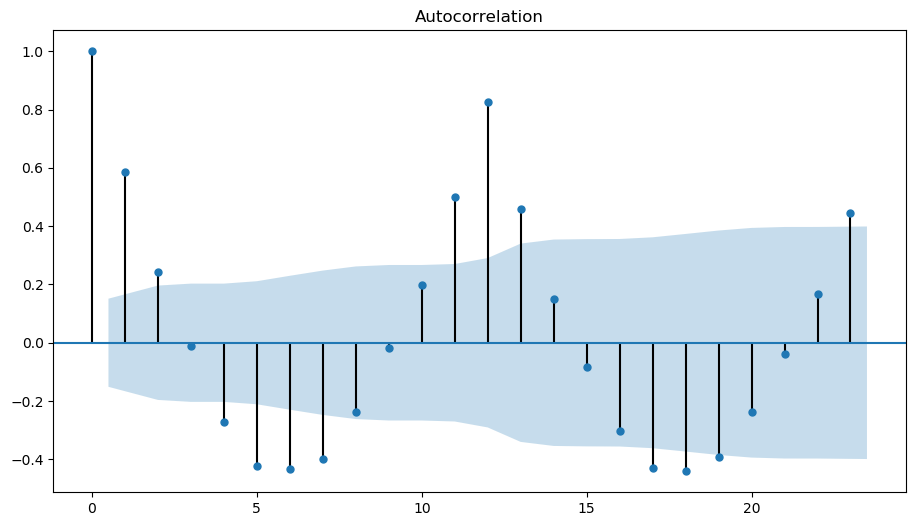

In [18]:
# Suposem que les dades sense heterocedasticitat ni tendència s'anomenen train_log_no_trend
plot_acf(train_log_no_trend)
plt.show()

Aquest gràfic es llegeix com l'anterior. Només començar hi ha dos valors fora de l'interval (recordem que el lag0 no ho comptem), amb la qual cosa q = 2. Quan es repeteix el cicle, és a dir, a partir del valor 11, hi ha dos valors fora de l'interval, amb això qual Q = 2.

Com que les dades no tenen ni tendència ni heterocedasticitat (se l'hem treta en apartats anteriors), d = D = 0.

Com hem vist a l'apartat anterior, el cicle és 12, de manera que s = 12. 

## 1.2 Prediccions


<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Aplica un model SARIMA a les dades sense heterocedasticitat ni tendència. Pots fer servir SARIMAX (de <i>statsmodels.tsa.statespace.sarimax</i>) amb els paràmetres que acabem de veure. Mostra gràficament el resultat del model juntament amb la sèrie original per comparar si s'ajusta bé.
</div> 

Tal i com comenta l'exercici previ, els models SARIMA depenen del paràmetres (p,d,q)(P,D,Q)s, on els primers (minúscules) corresponen a AR, I, MA de la sèrie normal, o els segons (majúscules) a AR, I, MA amb estacionalitat. A partir de la correlació ACF i la correlació parcial:

    - PACF:  p = 1, P = 2,  (un pic al periode 1 i altres dos als 11 - 12)
    - ACF: q = 2, Q = 2 (tenim dos pics als periode 1 - 2 i 11 - 12)
    - No tenim tendència ni heterocedasticitat, ja que la hem eliminat: d = 0, D = 0
    - Cicles són de 12 periòdes: s = 12

Per tant tenim un model SARIMA (1,0,2),(2,0,2)12 on li estem dients tota la informació que hem esmentat.

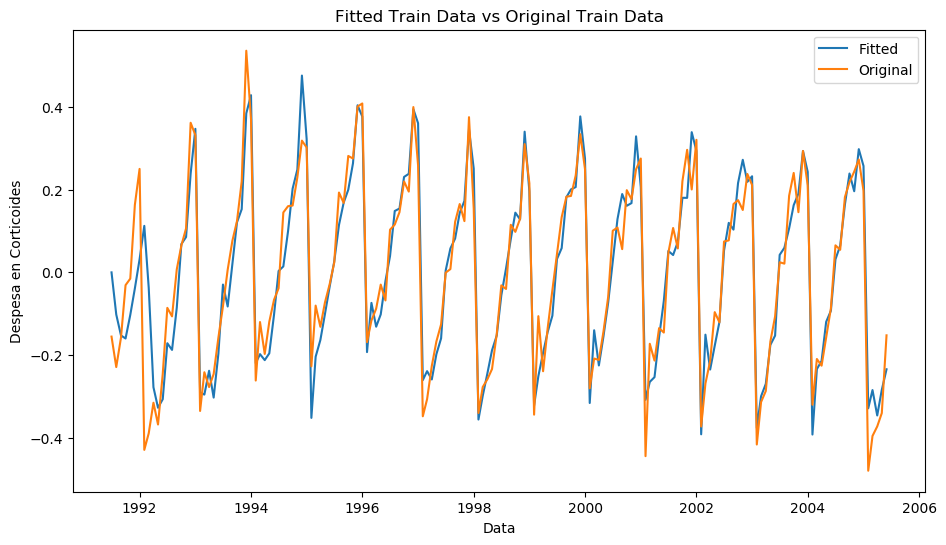

In [19]:
# apliquem el model on order són els parámetres de la serie normal i seasonal_order la estacionalitat:
sarimax_model = SARIMAX(train_log_no_trend, order=(1,0,2), seasonal_order=(2,0,2,12))
sarimax_fitted = sarimax_model.fit()

fig, (ax1) = plt.subplots(1)
ax1.plot(sarimax_fitted.fittedvalues, label = 'Fitted')
ax1.plot(train_log_no_trend, label = 'Original')
ax1.set_title('Fitted Train Data vs Original Train Data')

plt.xlabel('Data')
plt.ylabel('Despesa en Corticoides')
plt.legend(loc = 'best')
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Comenta els resultats que t'han sortit del model SARIMAX
</div> 

Un cop hem comparat el model fitat amb l'original (un cop hem extret la heterocedàsticitat i la tendència) podem veure que realment les diferències són molt petites i realment el model ajusta prou bé.

### 1.2.a. Predicció SARIMA (2.5 punts)

Utilitzarem el model SARIMA que hem filtrat abans per predir els tres propers anys (que són els anys que hem tret anteriorment). 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Genera tres anys de dades predites mitjançant el model SARIMA realitzat a l'apartat anterior. Grafica tota la sèrie (sense heterocedasticitat ni tendència), diferenciant amb colors diferents la sèrie real dels tres anys de predicció.
</div>

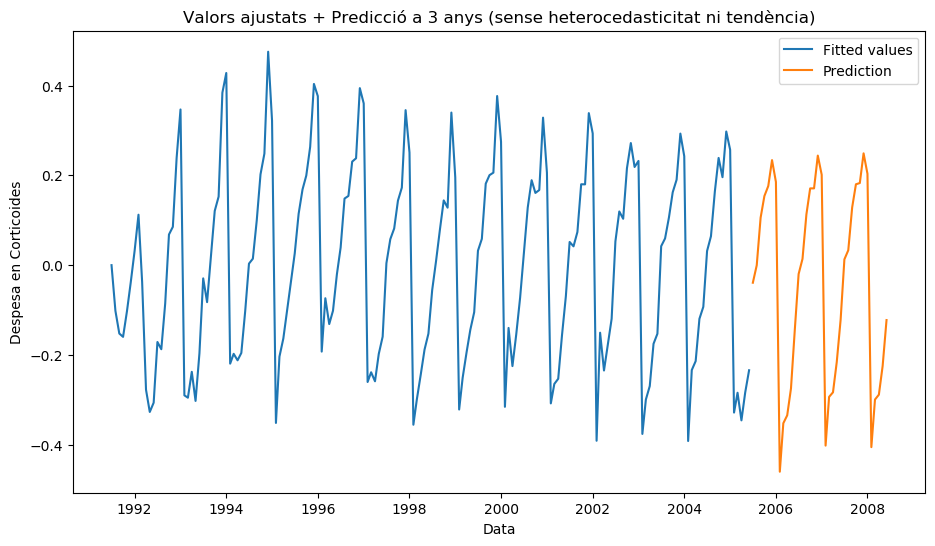

In [20]:
steps = x_test.size

fitted_values = sarimax_fitted.fittedvalues
prediction = sarimax_fitted.forecast(steps=steps)

fig, ax = plt.subplots()
ax.plot(fitted_values, label = 'Fitted values')
ax.plot(prediction, label = 'Prediction')
plt.xlabel('Data')
plt.ylabel('Despesa en Corticoides')
plt.legend(loc = 'best')
plt.title('Valors ajustats + Predicció a 3 anys (sense heterocedasticitat ni tendència)')
plt.show()

### 1.2.b. Tendència

Anteriorment hem vist que les dades de la sèrie temporal tenen una tendència lineal i l'hem calculada mitjançant una regressió lineal. Afegim aquesta tendència a la nostra predicció. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Afegeix a la sèrie anterior, la tendència trobada a l'apartat 1.1.b. Mostrar gràficament tota la sèrie (sense heterocedasticitat), diferenciant amb colors diferents la sèrie real dels dos anys de predicció.
</div> 

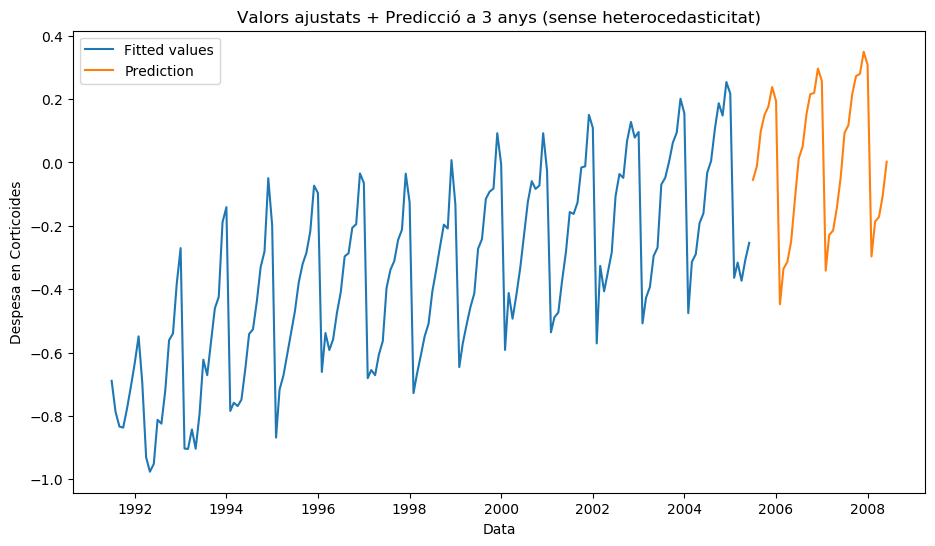

In [21]:
regr.fit(x_train.reshape(-1, 1), train_log)

# realitzem la predicció per la part de test
test_regr = regr.predict(x_test.reshape(-1, 1))

fitted_values_with_trend = fitted_values + train_regr
prediction_with_trend = prediction + test_regr

fig, ax = plt.subplots()
ax.plot(fitted_values_with_trend, label = 'Fitted values')
ax.plot(prediction_with_trend, label = 'Prediction')
plt.xlabel('Data')
plt.ylabel('Despesa en Corticoides')
plt.legend(loc = 'best')
plt.title('Valors ajustats + Predicció a 3 anys (sense heterocedasticitat)')
plt.show()

Hem afegit a tota la serie (valors fitats més la predicció de 3 anys) la tendència. Hem sumat la tendència de la sèrie original tant a la part de train (valors fitats) com a la predicció (valors de test). Hem fet servir el model de regressió dels punts anterior per a obtenir els valors de la tendència de la part de test.

### 1.2.c. Heterocedasticitat

Al primer apartat d'aquesta pràctica hem vist que la sèrie temporal té heterocedasticitat i l'hem eliminat transformant les dades. En aquest apartat farem la transfromació inversa per afegir heterocedasticitat a la nostra predicció. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Afegeix a la sèrie anterior, l'heterocedasticitat aplicant la funció inversa a la trobada a l'apartat 1.1.a. Mostrar gràficament tota la sèrie, diferenciant amb colors diferents la sèrie real dels anys de predicció.
</div> 

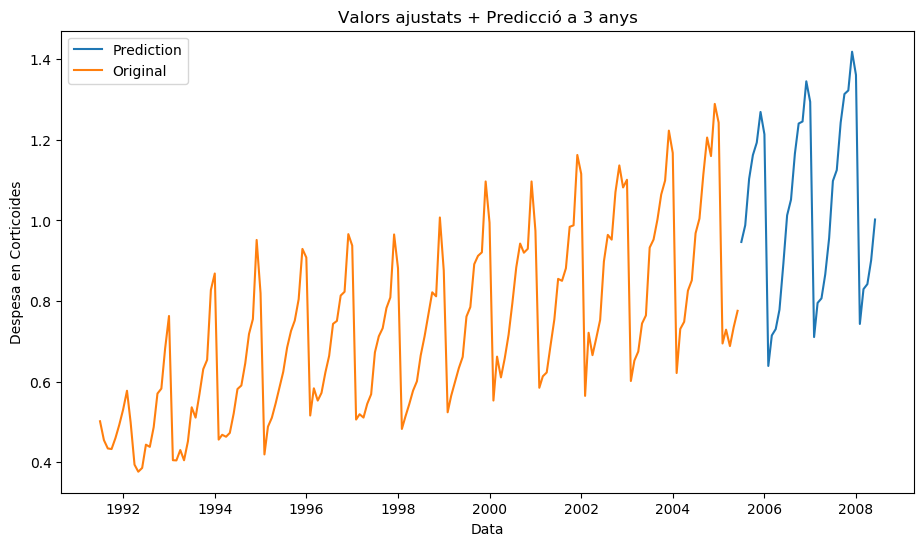

In [22]:
final_fitted_values = np.exp(fitted_values_with_trend) 
final_prediction = np.exp(prediction_with_trend) 

fig, ax = plt.subplots()
ax.plot(final_prediction, label = 'Prediction')
ax.plot(final_fitted_values, label = 'Original')
plt.xlabel('Data')
plt.ylabel('Despesa en Corticoides')
plt.legend(loc = 'best')
plt.title('Valors ajustats + Predicció a 3 anys')
plt.show()

Per afegir la heterocedasticitat només hem hagut de fer la operació inversa al ln(x) (logarítme base e) que hem aplicat per treure-la. Per tant, és unicament e(x).

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Afegeix al gràfic anterior les dades de test per veure si coincideixen amb la predicció.
</div> 

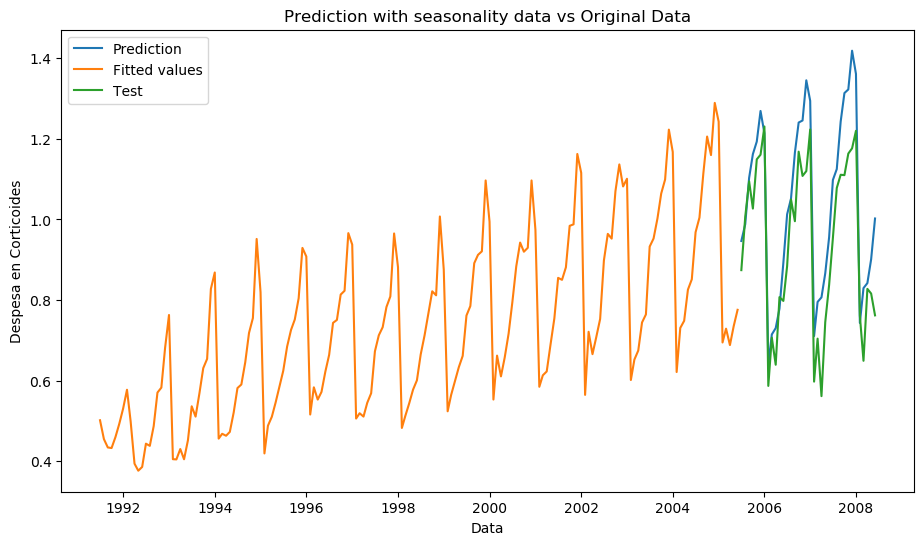

In [23]:
fig, ax = plt.subplots()
ax.plot(final_prediction, label = 'Prediction')
ax.plot(final_fitted_values, label = 'Fitted values')
ax.plot(test, label = 'Test')
ax.set_title('Prediction with seasonality data vs Original Data')

plt.xlabel('Data')
plt.ylabel('Despesa en Corticoides')
plt.legend(loc = 'best')
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Calcula l'error comès en test (per exemple, calcula l'MSE).
</div> 

In [24]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = test, y_pred = final_prediction)
print(f"Error de test (mse): {round(error_mse, 3)}")

Error de test (mse): 0.016


Encara que la predicció considero que és prou bona sembla que conforme és prediu més a futur aquesta predicció és pitjor. És a dir, el primer any la predicció té una precissió molt bona però aquesta baixa el segon any i encara més al tercer.

## 2. Combinació de classificadors (5 punts)

L'ensemble learning és una estratègia en què es fa servir un grup de models per resoldre un problema mitjançant la combinació estratègica de diversos models d'aprenentatge automàtic en un sol model predictiu.

En general, els mètodes d'ensemble s'utilitzen principalment per millorar la precisió del rendiment general d'un model i combinar diversos models diferents, també coneguts com a aprenents bàsics, per predir els resultats, en lloc d'utilitzar un sol model.

Per què entrenem tants classificadors diferents en lloc d'un de sol? Bé, l'ús de diversos models per predir el resultat final en realitat redueix la probabilitat de sospesar les decisions preses per models deficients (sobreentrenats, no degudament ajustats...).

Com més diversos siguin aquests aprenents bàsics, més poderós serà el model final.

Tinguem en compte que en qualsevol model daprenentatge automàtic, lerror de generalització ve donat per la suma de quadrats de bias + variància + error irreductible.

Els errors irreductibles són una cosa que està més enllà de nosaltres! No podem reduir-los.

Tot i això, utilitzant ensembles, podem reduir el biaix (bias) i la variància d'un model. Això redueix lerror de generalització general.

La **compensació de biaix-variança** és el punt de referència més important que diferencia un model robust d'un inferior (entenguem per inferior un model no gaire generalitzable).

Encara que no és una regla exacta, en l'aprenentatge automàtic, els models que tenen un biaix alt tendeixen a tenir una variància més baixa i viceversa.

Hem estat parlant de bias i variància. Vegem, però, que entenem per biaix d'un model i per variància d'un model.

1. **Sesgo**: El biaix és un error que sorgeix degut a suposicions falses realitzades en la fase d'aprenentatge d'un model. Un biaix alt pot fer que un algoritme daprenentatge ometi informació important i correlacions entre les variables independents i les etiquetes de classe, per la qual cosa no sajusta al model.

2. **Variança**: la variància ens diu que tan sensible és un model als petits canvis en les dades d'entrenament. És a dir, quant canvia el model. Una gran variació en un model ho farà propens al soroll aleatori present al conjunt de dades, per la qual cosa s'ajustarà massa al model.

Per comprendre amb més detall la compensació de biaix i variància en els models d'aprenentatge automàtic, podeu consultar aquest [article](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229).


Un cop arribats a aquest punt, podem dividir els ensembles en quatre categories:

1. **Bagging**: El bagging es fa servir principalment per reduir la variació en un model. Un exemple simple de bagging és l'algorisme Random Forest.

2. **Boosting**: El boosting s'utilitza principalment per reduir el biaix en un model. Exemples d'algorismes d'impuls són Ada-Boost, XGBoost, arbres de decisió millorats per gradient, etc.

3. **Stacking**: el stacking es fa servir principalment per augmentar la precisió de predicció d'un model. Per implementar el stacking farem servir la biblioteca mlextend proporcionada per scikit learn.

4. **Cascading**: aquesta classe de models són molt precisos. La connexió en cascada s'usa principalment en escenaris on no es pot permetre cometre un error. Per exemple, una tècnica en cascada es fa servir principalment per detectar transaccions fraudulentes amb targetes de crèdit.

## Dades

Per a aquest exercici farem servir el dataset *diabetes.csv*. Aquest conjunt de dades és original de l'Institut Nacional de Diabetis i Malalties Digestives i Renals. L'objectiu d'aquest dataset és predir basant-se en els mesuraments de diagnòstic si un pacient té diabetis.

En particular, tots els pacients són aquí dones d'almenys 21 anys d'ascendència índia Pima.

El dataset conté la següent informació

    - Embarassos: nombre d'embarassos
    - Glucosa: concentració de glucosa en plasma a 2 hores en una prova de tolerància a la glucosa oral
    - Pressió arterial: pressió arterial diastòlica (mm Hg)
    - SkinThickness: Gruix del plec cutani del tríceps (mm)
    - Insulina: insulina sèrica de 2 hores (mu U/ml)
    - IMC: índex de massa corporal (pes en kg / (alçada en m) ^ 2)
    - DiabetisPedigreeFunction: funció del pedigrí de la diabetis
    - Edat: Edat (anys)
    - Resultat (variable objectiu): variable de classe (0 o 1)

A la primera part d'aquest exercici veurem la combinació de classificadors en paral·lel mitjançant les tècniques de
**_Bagging_** i **_Boosting_**.

A la segona part intentarem millorar els resultats aplicant tècniques de combinació seqüencial de classificadors: **_Stacking_** i **_Cascading_**.

Per començar, vegem com és el dataset. 

In [25]:
diabetes = pd.read_csv('diabetes.csv')

nRow, nCol = diabetes.shape
print(f'Hi ha {nRow} files i {nCol} columnes')
diabetes.tail()

Hi ha 768 files i 9 columnes


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


Per poder provar diversos models, primer dividirem el dataset entre train i test.

Perquè tots obtingueu els mateixos resultats i poder comentar dubtes pel fòrum, fixarem la seed per obtenir els mateixos datasets de train i test.

Com que en aquest exercici tractarem stacking i cascading, i tots dos s'apliquen sobre el conjunt de test, farem un split del 50% per tenir una mica més de base en aplicar aquestes dues tècniques

In [37]:
X = diabetes.drop(columns = 'Outcome')
y = diabetes['Outcome']

myseed= 38
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=myseed)

## 2.1. Combinació paral·lela de classificadors (2 punts)

### 2.1.1. Arbres de decisió

Per poder comparar l'augment de performance obtingut a mesura que anem aplicant tècniques noves, utilitzarem com baseline un simple arbre de decisió. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Entrena un arbre de decisió sobre el conjunt de dades de train amb profunditat màxima de 3 nivells (aplicarem la mateixa restricció a les seccions següents). A continuació avalua sobre test i calcula'n la precisió aplicant validació creuada amb 5 conjunts.

<u>Suggeriment</u>: utilitzar el mòdul [*cross_val_score*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) de *sklearn*. Per aprendre més sobre [*cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) i sobre com fer servir aquests mòduls, us recomanem els següents enllaços:
</div> 

Crearem una funció que avaluarà els models amb cross validation sobre el train i posteriorment farem un entrenament i predicció sobre les dades de test. En ambdós casos calcularem l'accuracy.

In [27]:
# funció avaluatate_model
def avaluate_model(model, X_train, y_train, X_test, y_test):
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print('Train Scores: '+ str(scores))
    print("Train Accuracy: Mean %0.3f Std(+/-%0.3f)" %(scores.mean(), scores.std()))

    # fem la predicció amb el model entrenat sobre el conjunt de test
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # calculem l'accuracy
    score = accuracy_score(y_test, y_pred)
    print('\nTest Accuracy: %0.3f' %score)

In [28]:
# obtenim sempre els mateixos resultats
#np.random.seed(1234)

# creem el model
tree = DecisionTreeClassifier(max_depth=3)
# avaluem el model
avaluate_model(tree, X_train, y_train, X_test, y_test)

Train Scores: [0.77922078 0.68831169 0.76623377 0.76623377 0.69736842]
Train Accuracy: Mean 0.739 Std(+/-0.038)

Test Accuracy: 0.753


<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts
</div> 

El resultat és relativament bó el que  Més d'un 70% de les prediccions s'estàn classificant de forma correcte i tenim una desviació en els 5 models generats de 0.038. El resultat ens està retornant l'accuracy, és a dir, les mostres ben classificades entre les totals. 

Quan fem les prediccion sobre el conjunt de test, veiem que tenim uns valors similars a la mitja del conjunt de train. En aquesta cas, amb el conjunt que hem triat de test al fer l'split, està una mica per sobre de la mitja.

### 2.1.2.a. *Bagging*

La idea central del bagging és fer servir rèpliques del conjunt de dades original i utilitzar-les per entrenar diferents classificadors.

Crearem subconjunts mostrant aleatòriament un munt de punts del conjunt de dades d'entrenament amb reemplaçament.

Ara entrenarem classificadors individuals a cadascun d'aquests subconjunts bootstrap.

Cadascun daquests classificadors base predirà letiqueta de classe per a un problema donat. Aquí és on combinem les prediccions de tots els models base. Aquesta part s'anomena etapa d'agregació. És per això que trobareu els ensembles bagging pel nom d'ensembles d'agregació.

En general, es fa servir un vot de majoria simple en un sistema de classificació i es pren la mitjana de totes les prediccions per als models de regressió per combinar tots els classificadors base en un sol model i proporcionar el resultat final del model de conjunt.

Un exemple simple d'aquest enfocament és l'algorisme Random Forest. El bagging redueix l'alta variació (variància) d'un model, reduint així l'error de generalització. És un mètode molt eficaç, especialment quan tenim dades molt limitades amb el nostre cas.

Mitjançant lús de mostres de bootstrap, podem obtenir una estimació afegint les puntuacions de moltes mostres. 




**Com faríem el bagging?**

Suposem que tenim un conjunt d´entrenament que conté 100.000 punts de dades.

Crearíem N subconjunts mostrant a l'atzar 50K punts de dades per a cada subconjunt.

Cadascun daquests N subconjunts sutilitzarà per entrenar N classificadors diferents.

A l'etapa d'agregació, totes aquestes N prediccions es combinaran en un sol model, també anomenat metaclassificador.

Dels 100.000 punts presents originalment al conjunt de dades, si eliminem 1000 punts, l'impacte que tindrà als conjunts de dades mostrades serà molt inferior.

Si pensem intuïtivament, és possible que alguns d'aquests 1000 punts no siguin presents a tots els conjunts de dades mostrades i, per tant, la quantitat de punts que s'eliminaran de cada conjunt de dades mostrades serà molt inferior. Fins i tot zero en alguns casos! En resum, l'impacte d'eliminar 1000 punts d'aquest tipus serà en realitat menor als classificadors base, cosa que reduirà la variació en un model i ho farà més sòlid.

La variància no és més que sensibilitat al soroll, com hem comentat anteriorment. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Entrena un <i>random forest</i> sobre el conjunt de dades de train amb <b>20 arbres</b> de decisió i <b>profunditat màxima de 3</b > nivells. A continuació avalua sobre test i calcula'n la precisió aplicant validació creuada amb 5 conjunts.

<u>Suggeriment</u>: utilitzar el mòdul [*RandomForestClassifier*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) de *sklearn*. Per a aprendre a utilitzar aquest mòdul us recomanem el següent enllaç:
</div> 

In [29]:
np.random.seed(1234)

# creem el model
forest = ensemble.RandomForestClassifier(max_depth=3, n_estimators=20)

# avaluem el model
avaluate_model(forest, X_train, y_train, X_test, y_test)

Train Scores: [0.77922078 0.72727273 0.75324675 0.80519481 0.69736842]
Train Accuracy: Mean 0.752 Std(+/-0.038)

Test Accuracy: 0.750


El bagging en principi ens havia de fer reduïr la variança del model. El que fa és crear diferents repliques del model inicial i entrenar-los. Cada grup realitza una predicció de classe de cada element i agafem el que té més "vots". En el nostre cas si té diabetes o no. 

Si mirem els resultats hem millorat tímidament l'accuracy i la variabilitat en les execucions en train es mantenen igual. Segurament no millorem aquesta variabilitat perquè no dispossem d'una mostra amb moltes dades.

### 2.1.2.b. *Boosting*

El boosting s'utilitza per convertir els classificadors de base feble en forts. Els classificadors febles generalment tenen una correlació molt feble amb les etiquetes de classe veritables i els classificadors forts tenen una correlació molt alta entre el model i les etiquetes de classe veritables.

El boosting capacita els classificadors febles de manera iterativa, cadascun tractant de corregir l'error comès pel model anterior. Això s'aconsegueix entrenant un model feble en totes les dades d'entrenament, tot construint un segon model que té com a objectiu corregir els errors comesos pel primer model. Després construïm un tercer model que intenta corregir els errors comesos pel segon model i així successivament. Els models s'afegeixen de manera iterativa fins que el model final ha corregit tots els errors comesos per tots els models anteriors.

Quan s'afegeixen els models a cada etapa, s'assignen alguns pesos al model relacionat amb la precisió del model anterior. Després d'afegir un classificador feble, els pesos es tornen a ajustar. Els punts classificats incorrectament reben pesos més alts i els punts classificats correctament reben pesos més baixos. Aquest enfocament farà que el següent classificador se centri en els errors comesos pel model anterior.

El boosting redueix l'error de generalització prenent un model d'alt bias i baixa variància i reduint el bias en un nivell significatiu. Recordeu, el bagging redueix la variància. Com el bagging, el boosting també ens permet treballar amb models de classificació i regressió.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Entrena un gradient boosting sobre el conjunt de dades de train amb 20 arbres de decisió i profunditat màxima de 3 nivells. A continuació avalua sobre test i calcula'n la precisió aplicant validació creuada amb 5 conjunts.

Consell: utilitzar el mòdul [*GradientBoostingClassifier*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) de sklearn.
</div> 

In [30]:
np.random.seed(1234)

# creem el model
boosting = ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=20)

# avaluem el model
avaluate_model(boosting, X_train, y_train, X_test, y_test)

Train Scores: [0.76623377 0.7012987  0.67532468 0.79220779 0.72368421]
Train Accuracy: Mean 0.732 Std(+/-0.042)

Test Accuracy: 0.758


En aquest tercer cas tornem a tenir un model amb una precissió molt similar en quant l'accuracy.

## 2.2. Combinació seqüencial de classificadors base diferents (3 punts)

Per poder fer combinació seqüencial de models, necessitem tenir diversos models diferents entrenats.

En el nostre cas ja tenim un arbre de decisió. Entrenarem un parell de models més. 

### 2.2.1 KNN (k veïns més propers)
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Entrena un <i>k-neighbors</i> amb 2 veïns sobre el conjunt de dades de train. A continuació avalua sobre test i calcula'n la precisió aplicant validació creuada amb 5 conjunts.
</div> 

In [31]:
np.random.seed(1234)

knn = KNeighborsClassifier(n_neighbors=2, weights='uniform')

# avaluem el model
avaluate_model(knn, X_train, y_train, X_test, y_test)

Train Scores: [0.67532468 0.66233766 0.68831169 0.74025974 0.69736842]
Train Accuracy: Mean 0.693 Std(+/-0.027)

Test Accuracy: 0.701


### 2.2.2 SVM (Support Vector Machines)
<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Entrena un SVM amb gamma = 0.01 sobre el conjunt de dades de train. A continuació avalua sobre test i calcula'n la precisió aplicant validació creuada amb 5 conjunts.
</div> 

In [32]:
np.random.seed(1234)

svc = svm.SVC(gamma=0.01)

# avaluem el model
avaluate_model(svc, X_train, y_train, X_test, y_test)

Train Scores: [0.66233766 0.62337662 0.67532468 0.67532468 0.68421053]
Train Accuracy: Mean 0.664 Std(+/-0.022)

Test Accuracy: 0.661


### 2.2.3 *Stacking*
Tots els models individuals s'entrenen per separat en el conjunt complet de dades d'entrenament i s'ajusten per aconseguir més precisió. La compensació de bias i variància es té en compte per a cada model. El model final, també conegut com a metaclassificador, s'alimenta de les etiquetes de classe predites pels models base o de les probabilitats predites per a cada etiqueta de classe. Després, el metaclassificador s'entrena en funció dels resultats donats pels models base.

Al stacking, s'entrena un nou model en funció de les prediccions realitzades pels models anteriors.
Aquest procés es duu a terme de manera seqüencial. Això significa que diversos models s'entrenen a l'etapa 1 i s'ajusten amb precisió. Les probabilitats pronosticades de cada model de l'etapa 1 s'alimenten com a entrada a tots els models a l'etapa 2. Els models a l'etapa 2 després s'ajusten amb precisió i les sortides corresponents s'alimenten als models a l'etapa 3 i així successivament . Aquest procés es produeix diverses vegades en funció de la quantitat de capes d'apilament que voleu utilitzar.

L'etapa final consisteix en un únic model que ens dóna el resultat final en combinar el resultat de tots els models presents a les capes anteriors.

Sovint, lús de classificadors apilables augmenta la precisió de predicció dun model. Però de cap manera no es pot garantir que l'ús d'apilament augmenti la precisió de la predicció en tot moment!
Feu una ullada al següent [link](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/) 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Construeix un classificador de <i>stacking</i> usant un <i>Gradient Boosting</i> (amb <b>20 arbres</b> de decisió i <b>profunditat màxima de 3</b> nivells) que utilitzi com a atributs les prediccions fetes al conjunt de test pels algorismes: arbre de decisió, knn, svm. Calcula la precisió del model resultant amb *cross-validation* en el conjunt de test (en aquest cas no tenim conjunt de train, amb la qual cosa es fa directament cross-validation sobre test).

<u>Suggeriment</u>: utilitzar la funció [column_stack](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html) de numpy per ajuntar totes les prediccions.
</div> 

In [33]:
np.random.seed(1234)

# specifiquem els models
_tree = DecisionTreeClassifier(max_depth=3)
_knn = KNeighborsClassifier(n_neighbors=2, weights='uniform')
_svc = svm.SVC(gamma=0.01)

# fittem els models amb les dades de train
_tree = _tree.fit(X_train, y_train)
_knn = _knn.fit(X_train, y_train)
_svc = _svc.fit(X_train, y_train)

# fem les prediccions dels estimadors base
y_pred_tree = _tree.predict(X_test)
y_pred_knn = _knn.predict(X_test)
y_pred_svc = _svc.predict(X_test)

# apilem les prediccions de sortida per a fer servir com a dades d'entrenament del meta model
stacked_predictions = np.column_stack((y_pred_tree, y_pred_knn, y_pred_svc))

# creem el meta model
meta_model = ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=20)

# calculem el score del model generat amb les dades de les prediccions de les sortides dels models base
scores = cross_val_score(meta_model, stacked_predictions, y_test, cv=5, scoring='accuracy')

print("Stacking Accuracy: %0.2f (+/- %0.2f)"  % (scores.mean(), scores.std()))

Stacking Accuracy: 0.76 (+/- 0.03)


El que hem fet és entrenar el models tree, knn i svmi posteriorment fer les prediccions. Aquestes prediccions les utilitzem com paràmere X en el meta_model i com a Y les y_test. 

Hem aconseguit millorar les prediccions respecte KNN (0.693 +/-0.027), Arbres de decissió (0.739 +/-0.038) i Support Vector Machine (0.664 +/-0.022). El valor de l'accuracy és de: 0.76 (+/- 0.03)

Anem a realitzar el mateix exercici però fent servir la classe StackingClassifier que realitza la mateixa operativa que hem comentat abans. Les sortides dels estimadors base com a entrada del meta learner o estimador final.

In [34]:
np.random.seed(1234)

_tree = DecisionTreeClassifier(max_depth=3)
_knn = KNeighborsClassifier(n_neighbors=2, weights='uniform')
_svc = svm.SVC(gamma=0.01)

# creem els estimadors base
base_learners = [('rf_1', _tree),('rf_2', _knn),('rf_3', _svc)]

# creem el meta learner
_boosting = ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=20)

# inicialitzem l'StackingClassifier amb el meta learner i els estimadors base
clf = ensemble.StackingClassifier(estimators=base_learners, final_estimator=_boosting, cv=5)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

# obtenim l'score del meta learner
final_score = clf.fit(X_train, y_train).score(X_test, y_test)

print("Stacking Train accuracy: %0.2f (+/- %0.2f)"  % (scores.mean(), scores.std()))
print("Stacking Test accuracy: %0.2f"  % (final_score))

Stacking Train accuracy: 0.73 (+/- 0.04)
Stacking Test accuracy: 0.72


Hem obtingut pitjor resultat que si el fem nosaltres "manualment".

<div class="alert alert-block alert-info">
     <strong>Anàlisi:</strong> Has aconseguit millorar la precisió gràcies a l'<i>stacking</i>? Comenta'n els resultats.
</div> 

Realment hem millorat amb l'stacking sense fer servir la classe StackingClassifier no de forma espectacular però si apreciable sobretot respecte SVN i KNN. Els arbres de decissió des de un inici tenien força bons resultats.

### 2.2.4 *Cascading*

El cas de cascading és semblant al de stacking però utilitzant no només les prediccions parcials dels classificadors base, sinó també les dades originals.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Per això construïm un classificador de cascading usant un Gradient Boosting (amb 20 arbres de decisió i profunditat màxima de 3 nivells) que utilitza com a atributs les prediccions obtingudes amb els models anteriors en el conjunt de test ( igual que amb el stacking), i també les variables originals.
Calcula la precisió del model resultant amb *cross-validation* al conjunt de test. Suggeriment: Fes servir el mateix conjunt de dades que a l'exercici anterior però afegeix `X_test`.
</div> 

In [35]:
np.random.seed(1234)

# specifiquem els models
_tree = DecisionTreeClassifier(max_depth=3)
_knn = KNeighborsClassifier(n_neighbors=2, weights='uniform')
_svc = svm.SVC(gamma=0.01)

# fittem els models amb les dades de train
_tree = _tree.fit(X_train, y_train)
_knn = _knn.fit(X_train, y_train)
_svc = _svc.fit(X_train, y_train)

# fem les prediccions dels estimadors base
y_pred_tree = _tree.predict(X_test)
y_pred_knn = _knn.predict(X_test)
y_pred_svc = _svc.predict(X_test)

# apilem les prediccions de sortida per a fer servir com a dades d'entrenament del meta model i afegim X_train
stacked_predictions = np.column_stack((y_pred_tree, y_pred_knn, y_pred_svc, X_test))

# creem el meta model
meta_model = ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=20)

# calculem el score del model generat amb les dades de les prediccions de les sortides dels models base
final_score = cross_val_score(meta_model, stacked_predictions, y_test, cv=5, scoring='accuracy')
print("Cascading Train Accuracy: %0.2f (+/- %0.2f)"  % (scores.mean(), scores.std()))

Cascading Train Accuracy: 0.73 (+/- 0.04)


Hem fet exactament el mateix que amb stacking però a més de les sortides de les prediccions base, hem afegit al column stack que genera les entrades del meta model (GradientBoostingClassifier) les entrades inicials del dataset (x_test)

In [36]:
np.random.seed(1234)

_tree = DecisionTreeClassifier(max_depth=3)
_knn = KNeighborsClassifier(n_neighbors=2, weights='uniform')
_svc = svm.SVC(gamma=0.01)

# creem els estimadors base
base_learners = [('rf_1', _tree),('rf_2', _knn),('rf_3', _svc)]

# creem el meta learner
_boosting = ensemble.GradientBoostingClassifier(max_depth=3, n_estimators=20)

# inicialitzem l'StackingClassifier amb el meta learner i els estimadors base
clf = ensemble.StackingClassifier(estimators=base_learners, final_estimator=_boosting, cv=5, passthrough=True)

# obtenim l'score del meta learner
final_score = clf.fit(X_train, y_train).score(X_test, y_test)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print("Cascading Train accuracy: %0.2f (+/- %0.2f)"  % (scores.mean(), scores.std()))
print("Cascading Test accuracy: %0.2f"  % (final_score))

Cascading Train accuracy: 0.73 (+/- 0.03)
Cascading Test accuracy: 0.76


En aquest darrer exemple hem realitzat un estudi amb cascading però amb la classe StackingClassifier que automatitza el procés. Aquest cop hem tingut millors resultats que quan l'hem fet de forma manual.

<div class="alert alert-block alert-info">
     <strong>Anàlisi:</strong> Has aconseguit millorar la precisió gràcies al <i>cascading</i>? Comenta'n els resultats.
</div> 

Tant amb cascading com amb stacking hem aconseguit millorar l'accuracy dels models. Podem dir que Stacking és el que ha obtingut millors resultats ja que tenim uns valors de 0.76 (+/- 0.03) enfront dels 0.73 (+/- 0.04) de Cascading. Millor accuracy i menor desviament amb les dades de train. Si fessim una prova amb els valors de test (no entrenats) tindriem valors similars.

També podriem haver dividit el conjunt de test en 2 per a poder provar una predicció real però el dataset realment té poca mostra.

# Bibliografia utilitzada 

- [Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia](https://otexts.com/fpp3/) 

- [Time Series Analysis and Forecasting with ADAM Ivan Svetunkov](https://openforecast.org/adam/)

- [Python Data Science Handbook by Jake VanderPlas](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83) 

- [Python for Finance: Mastering Data-Driven Finance](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055) 